In [949]:
from helpers import *
import pandas as pd
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# auto reloading library (mainly for altering helpers.py)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [950]:
pd.set_option('display.max_columns', None)

In [951]:
training_filters = [
    {
        'feature': 'month',
        'operator': 'between',
        'value': [3, 9]
    },
]

validation_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2020-05-01', '2020-07-01']
    }
]

test_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2021-05-01', '2021-07-01']
    }
]

In [952]:
agg_strats = ['min','max']
#agg_strats = ['mean']


m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = ['clip','sun_el_thr'],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}


In [953]:
# get data
# X_train, y_train = m_wrap.get_train(aggregated=False,drop_val=True,drop_test=False)
# X_val, y_val = m_wrap.get_val(aggregated=False)
# X_test, y_test = m_wrap.get_test(aggregated=False)
# X_sub = m_wrap.get_sub(aggregated=False)
# X_test, y_test = m_wrap.get_test(aggregated=False)


X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=True,y_scaled=True)
#X_val_agg, y_val_agg = m_wrap.get_val(aggregated=True)
X_test_agg, y_test_agg = m_wrap.get_test(aggregated=True,y_scaled=False)
X_sub_agg = m_wrap.get_sub(aggregated=True)

In [954]:
val_idx = X_train_agg['date_forecast'].between('2020-05-01', '2020-07-01')-1
ps = PredefinedSplit(test_fold=val_idx)

In [955]:
# imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# exclude datetime columns
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])
#X_val_agg = X_val_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()

print(f"categorical_features: {categorical_features}")
print(f"impute_features: {impute_features}")


columnTransformer = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='constant'),impute_features),
        ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ],
    remainder='passthrough',  # Dont drop remaining columns
    n_jobs=-1
)

mod = XGBRegressor(
    # reg_lambda=10,
    # reg_alpha=10,
    min_child_weight=5,
    learning_rate=0.03,
    max_depth=7,
    n_estimators=300,
    objective='reg:absoluteerror',
)

mod = CatBoostRegressor(
    objective='MAE',
    iterations=800,
    depth=8,
)

open('status.csv', 'w').close()
# build the pipeline
mod_pipe = Pipeline(steps=[
    ('columnTransformer', columnTransformer),
    ('statusSaver', StatusSaver()),
    ('estimator', mod)
])

categorical_features: ['building_id']
impute_features: ['delta_forecast', 'min_ceiling_height_agl:m', 'min_cloud_base_agl:m', 'min_snow_density:kgm3', 'min_effective_cloud_cover_5h_mean', 'min_GHI_lag_-1h', 'min_GHI_lag_1h', 'min_temp*GHI_lag_-1h', 'min_temp*GHI_lag_1h', 'max_ceiling_height_agl:m', 'max_cloud_base_agl:m', 'max_snow_density:kgm3', 'max_effective_cloud_cover_5h_mean', 'max_GHI_lag_-1h', 'max_GHI_lag_1h', 'max_temp*GHI_lag_-1h', 'max_temp*GHI_lag_1h']


In [956]:
def std_per_sample(y, y_pred):
    return np.std((y - y_pred), axis=0)

std_scorer = make_scorer(std_per_sample, greater_is_better=False)

scoring = {
    'MAE': 'neg_mean_absolute_error',
    'STD': std_scorer
}

In [957]:
# run grid search
gs = GridSearchCV(
    mod_pipe,
    param_grid={
        'estimator__verbose': [1],
        # 'estimator__learning_rate': np.arange(0.1, 0.001, -0.010),
        # 'estimator__max_depth': np.arange(13, 1, -1)
        # 'estimator__n_estimators': np.arange(500,100,-50),
        # 'estimator__colsample_bytree': np.arange(0.0,1.0001,0.025),
        # 'estimator__reg_alpha': np.arange(0, 15, 1)
        # 'estimator__reg_lambda': np.arange(0, 30, 1),
        # 'estimator__min_child_weight': np.arange(0,10,1),
        # 'estimator__l2_leaf_reg': [0, 1, 3, 6, 10],
        # 'estimator__depth' : [5,6,7,8],
        # 'estimator__iterations': [800, 1000, 1200],

    },
    cv=ps,
    n_jobs=-1,
    scoring=scoring,
    verbose=2,
    refit='MAE'
)

# bs = BayesSearchCV(
#     mod_pipe,
#     search_spaces={
#         'estimator__learning_rate': Real(0.05, 0.3),
#         'estimator__max_depth': Integer(3, 13),
#         'estimator__n_estimators': Integer(20,500),
#         'estimator__colsample_bytree': Real(0.001,1),
#         'estimator__reg_alpha': Real(0, 50),
#         'estimator__reg_lambda': Real(0, 50),
#         'estimator__min_child_weight': Real(0,50)
#     },
#     cv=ps,
#     n_jobs=-1,
#     scoring='neg_mean_absolute_error',
#     verbose=2,
#     n_iter=150,
#     n_points=6,
#     return_train_score=True
# )

gs.fit(X_train_agg, y_train_agg)


Fitting 1 folds for each of 1 candidates, totalling 1 fits
0:	learn: 0.1696351	total: 21.1ms	remaining: 16.9s
1:	learn: 0.1651650	total: 38.6ms	remaining: 15.4s
2:	learn: 0.1606188	total: 55.3ms	remaining: 14.7s
3:	learn: 0.1562689	total: 71.2ms	remaining: 14.2s
4:	learn: 0.1521448	total: 90.3ms	remaining: 14.4s
5:	learn: 0.1483401	total: 105ms	remaining: 13.9s
6:	learn: 0.1445113	total: 120ms	remaining: 13.6s
7:	learn: 0.1409681	total: 136ms	remaining: 13.4s
8:	learn: 0.1374303	total: 158ms	remaining: 13.9s
9:	learn: 0.1340123	total: 178ms	remaining: 14s
10:	learn: 0.1305940	total: 197ms	remaining: 14.1s
11:	learn: 0.1274523	total: 215ms	remaining: 14.1s
12:	learn: 0.1243689	total: 236ms	remaining: 14.3s
13:	learn: 0.1214561	total: 256ms	remaining: 14.4s
14:	learn: 0.1185752	total: 274ms	remaining: 14.3s
15:	learn: 0.1157938	total: 290ms	remaining: 14.2s
16:	learn: 0.1132539	total: 306ms	remaining: 14.1s
17:	learn: 0.1107214	total: 322ms	remaining: 14s
18:	learn: 0.1082766	total: 339m

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=Pipeline(steps=[('columnTransformer',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('imputer',
                                                                         SimpleImputer(strategy='constant'),
                                                                         ['delta_forecast',
                                                                          'min_ceiling_height_agl:m',
                                                                          'min_cloud_base_agl:m',
                                                                          'min_snow_density:kgm3',
                                                                          'min_effective_cloud_cover_5h_m...
                                                                          'max_temp*GHI_lag_1h']),
                                                                        ('oneHotEncoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['building_id'])])),
                                       ('statusSaver', StatusSaver()),
                                       ('estimator',
                                        <catboost.core.CatBoostRegressor object at 0x2aeeeaf10>)]),
             n_jobs=-1, param_grid={'estimator__verbose': [1]}, refit='MAE',
             scoring={'MAE': 'neg_mean_absolute_error',
                      'STD': make_scorer(std_per_sample, greater_is_better=False)},
             verbose=2)

In [958]:
gs.best_params_

{'estimator__verbose': 1}

In [959]:
model = gs.best_estimator_

In [960]:
# get val scores
# sns.lineplot(gs.cv_results_['mean_test_score'])

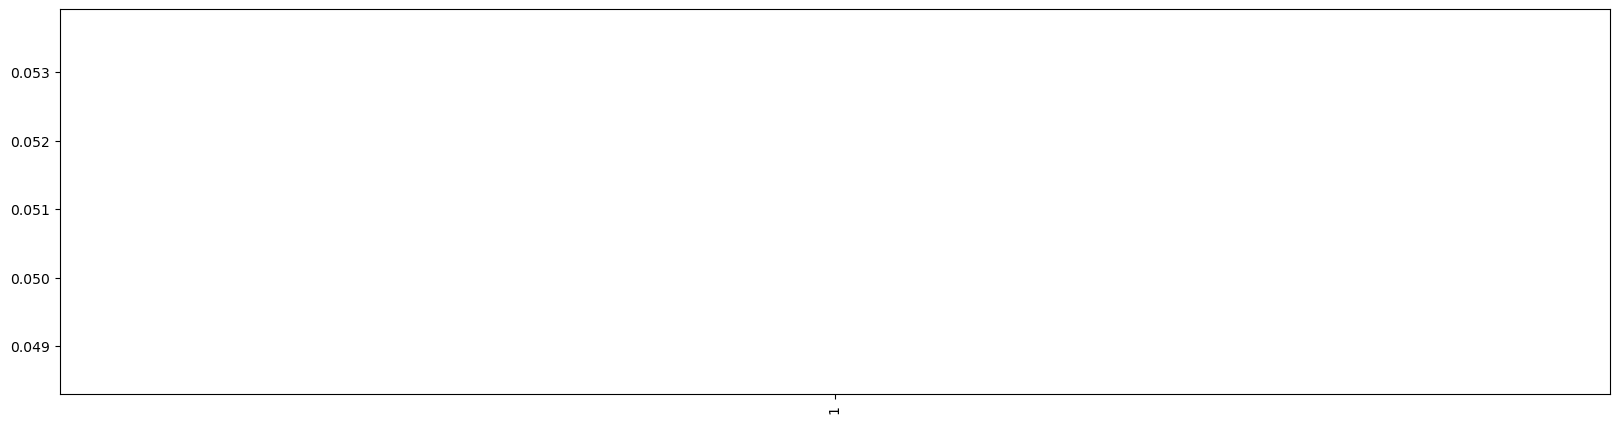

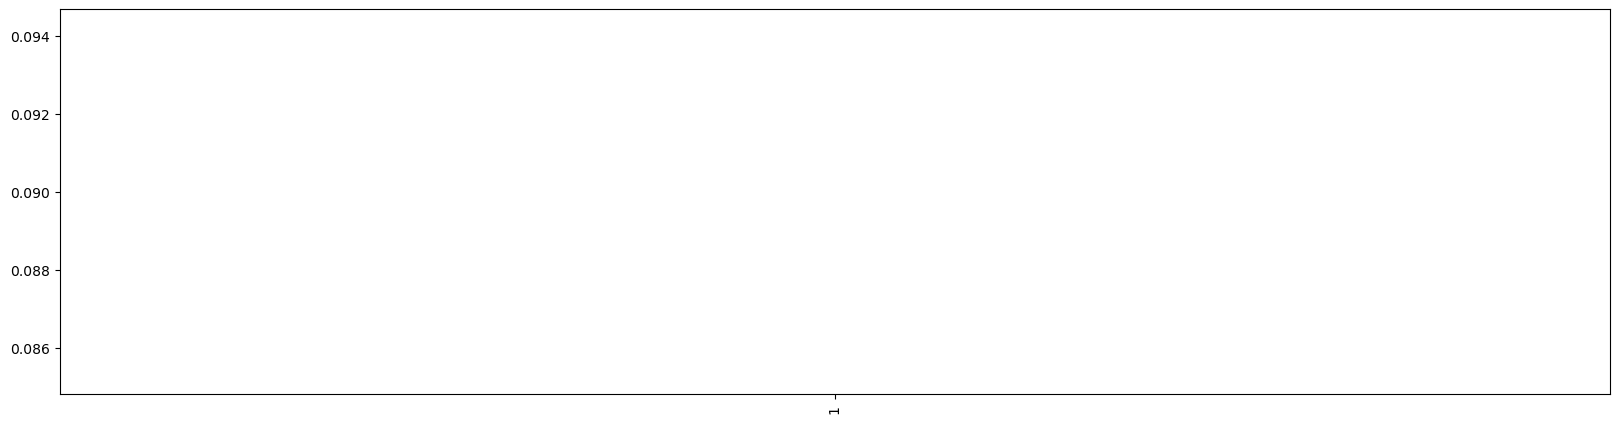

In [961]:
for key, values in gs.param_grid.items():
    pass

plt.figure(figsize=(20, 5))
# plt.ylim(0.05, 0.0525)
sns.lineplot(y=gs.cv_results_['mean_test_MAE']*-1, x=list(map(str, values)))
plt.xticks(rotation=90);

plt.figure(figsize=(20, 5))
sns.lineplot(y=gs.cv_results_['mean_test_STD']*-1, x=list(map(str, values)))
plt.xticks(rotation=90);

In [962]:
gs

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=Pipeline(steps=[('columnTransformer',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('imputer',
                                                                         SimpleImputer(strategy='constant'),
                                                                         ['delta_forecast',
                                                                          'min_ceiling_height_agl:m',
                                                                          'min_cloud_base_agl:m',
                                                                          'min_snow_density:kgm3',
                                                                          'min_effective_cloud_cover_5h_m...
                                                                          'max_temp*GHI_lag_1h']),
                                                                        ('oneHotEncoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['building_id'])])),
                                       ('statusSaver', StatusSaver()),
                                       ('estimator',
                                        <catboost.core.CatBoostRegressor object at 0x2aeeeaf10>)]),
             n_jobs=-1, param_grid={'estimator__verbose': [1]}, refit='MAE',
             scoring={'MAE': 'neg_mean_absolute_error',
                      'STD': make_scorer(std_per_sample, greater_is_better=False)},
             verbose=2)

In [963]:
pred = pd.Series(model.predict(X_test_agg))

In [964]:
mae = m_wrap.get_mae(pred,X_test_agg, y_test_agg, is_aggregated=True)
print(f'MAE: {mae}')

MAE: 143.46340194662324


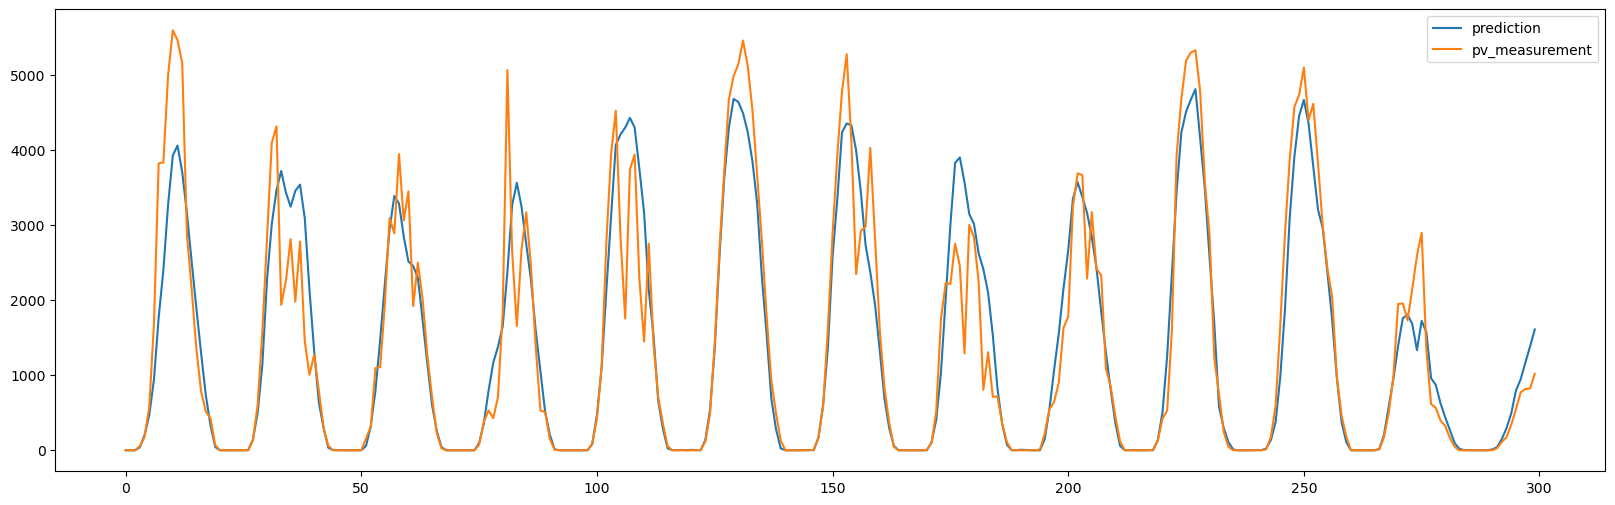

In [965]:
m_wrap.plot_Pred_vs_PV(pred,y_test_agg,X_test_agg,start_idx=0,end_idx=300)

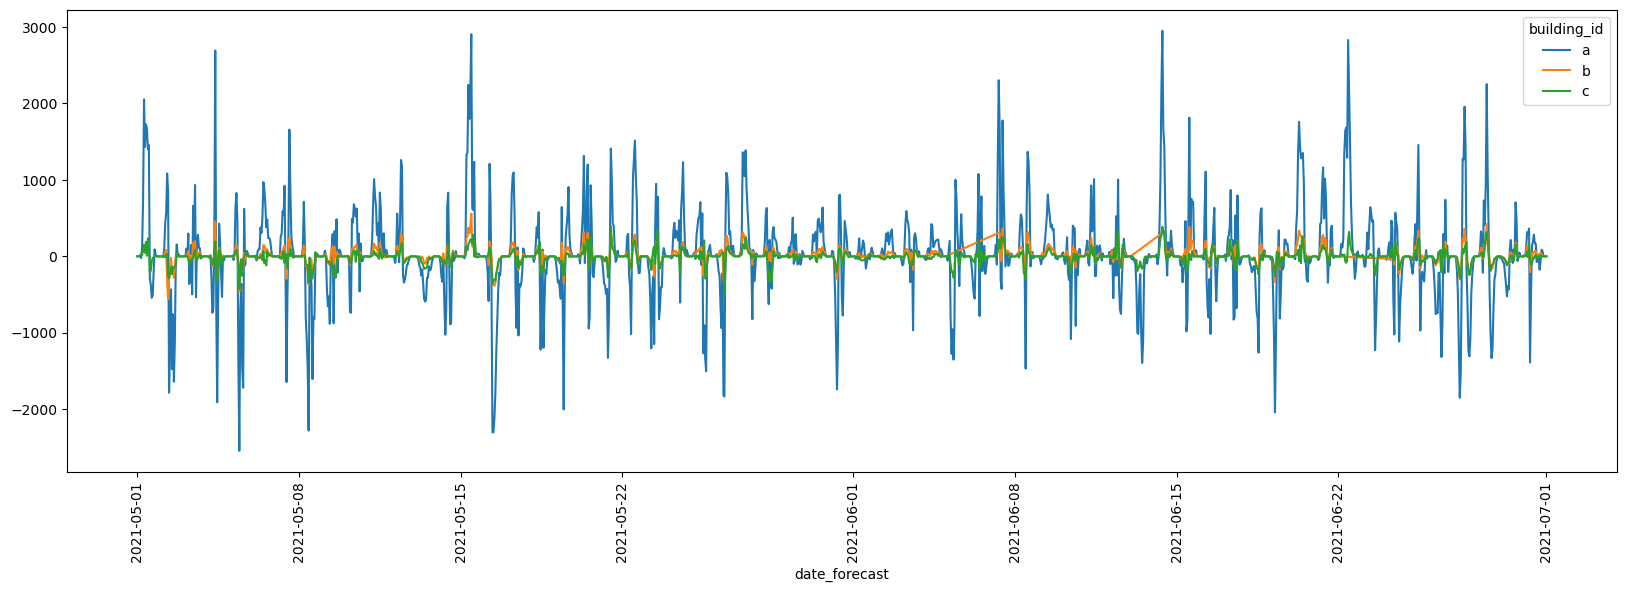

In [966]:
m_wrap.plot_Residuals(pred,y_test_agg,X_test_agg)

In [967]:
model

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('imputer',
                                                  SimpleImputer(strategy='constant'),
                                                  ['delta_forecast',
                                                   'min_ceiling_height_agl:m',
                                                   'min_cloud_base_agl:m',
                                                   'min_snow_density:kgm3',
                                                   'min_effective_cloud_cover_5h_mean',
                                                   'min_GHI_lag_-1h',
                                                   'min_GHI_lag_1h',
                                                   'min_temp*GHI_lag_-1h',
                                                   'min_temp*GHI_l...
                                                   'max_ceiling_height_agl:m',
                                                   'max_cloud_base_agl:m',
                                                   'max_snow_density:kgm3',
                                                   'max_effective_cloud_cover_5h_mean',
                                                   'max_GHI_lag_-1h',
                                                   'max_GHI_lag_1h',
                                                   'max_temp*GHI_lag_-1h',
                                                   'max_temp*GHI_lag_1h']),
                                                 ('oneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['building_id'])])),
                ('statusSaver', StatusSaver()),
                ('estimator',
                 <catboost.core.CatBoostRegressor object at 0x2fde187d0>)])

In [968]:
X_all, y_all = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=False,y_scaled=True)
X_all = X_all.select_dtypes(exclude=['datetime','timedelta','period[M]'])

model.fit(X_all, y_all)

0:	learn: 0.1805508	total: 24.8ms	remaining: 19.8s
1:	learn: 0.1756996	total: 46.3ms	remaining: 18.5s
2:	learn: 0.1710721	total: 66.4ms	remaining: 17.6s
3:	learn: 0.1664483	total: 87.2ms	remaining: 17.4s
4:	learn: 0.1620491	total: 110ms	remaining: 17.5s
5:	learn: 0.1577340	total: 130ms	remaining: 17.2s
6:	learn: 0.1537090	total: 153ms	remaining: 17.3s
7:	learn: 0.1498074	total: 172ms	remaining: 17s
8:	learn: 0.1460329	total: 197ms	remaining: 17.3s
9:	learn: 0.1422683	total: 222ms	remaining: 17.6s
10:	learn: 0.1387491	total: 252ms	remaining: 18.1s
11:	learn: 0.1353690	total: 281ms	remaining: 18.5s
12:	learn: 0.1321408	total: 307ms	remaining: 18.6s
13:	learn: 0.1289128	total: 331ms	remaining: 18.6s
14:	learn: 0.1257357	total: 357ms	remaining: 18.7s
15:	learn: 0.1227062	total: 413ms	remaining: 20.3s
16:	learn: 0.1198844	total: 436ms	remaining: 20.1s
17:	learn: 0.1171201	total: 459ms	remaining: 19.9s
18:	learn: 0.1145220	total: 481ms	remaining: 19.8s
19:	learn: 0.1119074	total: 505ms	remai

Pipeline(steps=[('columnTransformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('imputer',
                                                  SimpleImputer(strategy='constant'),
                                                  ['delta_forecast',
                                                   'min_ceiling_height_agl:m',
                                                   'min_cloud_base_agl:m',
                                                   'min_snow_density:kgm3',
                                                   'min_effective_cloud_cover_5h_mean',
                                                   'min_GHI_lag_-1h',
                                                   'min_GHI_lag_1h',
                                                   'min_temp*GHI_lag_-1h',
                                                   'min_temp*GHI_l...
                                                   'max_ceiling_height_agl:m',
                                                   'max_cloud_base_agl:m',
                                                   'max_snow_density:kgm3',
                                                   'max_effective_cloud_cover_5h_mean',
                                                   'max_GHI_lag_-1h',
                                                   'max_GHI_lag_1h',
                                                   'max_temp*GHI_lag_-1h',
                                                   'max_temp*GHI_lag_1h']),
                                                 ('oneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['building_id'])])),
                ('statusSaver', StatusSaver()),
                ('estimator',
                 <catboost.core.CatBoostRegressor object at 0x2fde187d0>)])

In [969]:
pred_sub = pd.Series(model.predict(X_sub_agg))
m_wrap.y_pred_to_csv(pred_sub, X_sub_agg, is_aggregated=True,name='catboost_all.csv',sun_el_thr=1)

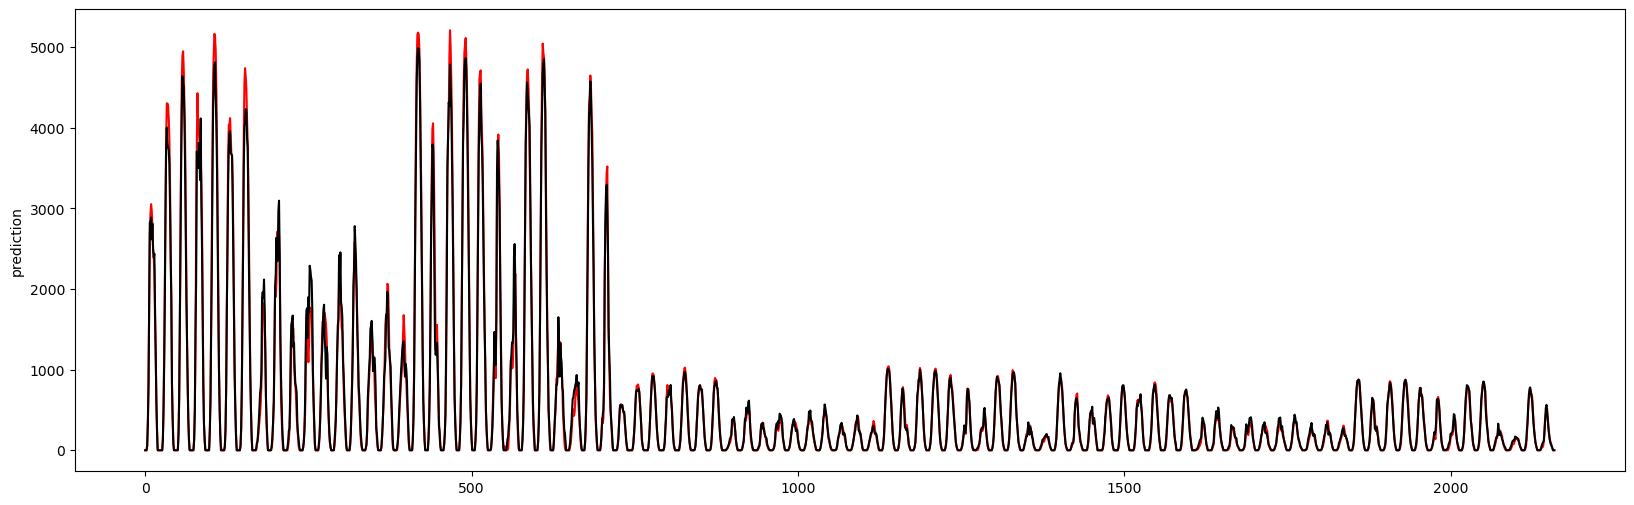

In [970]:
m_wrap.plot_yPredSub_vs_submission(pred_sub,X_sub_agg,sub_file='./submission_files/152_029_xgboost.csv')